Questo script serve per addestarre o caricare i modello con open clip rn 50 quickgelu

C:\Users\conca\Documents\progetti\progettoNLP\venv\lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Computing Embeddings: 100%|██████████| 300/300 [00:14<00:00, 20.02it/s]


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed


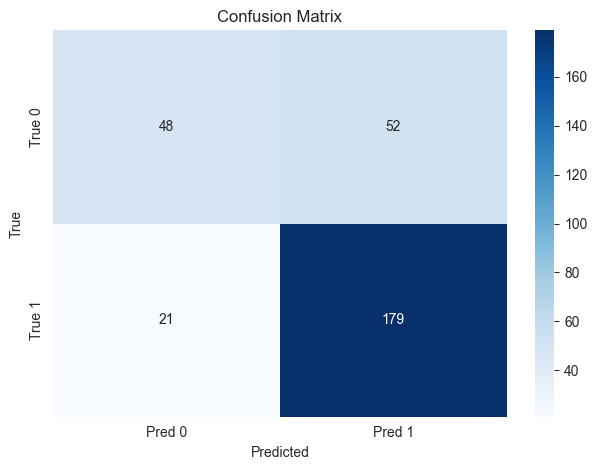


False Positives and False Negatives:
False Positive: Text='*** senate republicans @nrsc .@edmarkey, this you? #weneedni...', Label=0.0, Pred=1.0


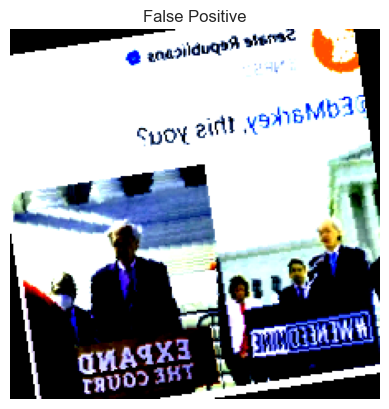

False Positive: Text='fjames webb telescope my goodness, the universe is massive b...', Label=0.0, Pred=1.0


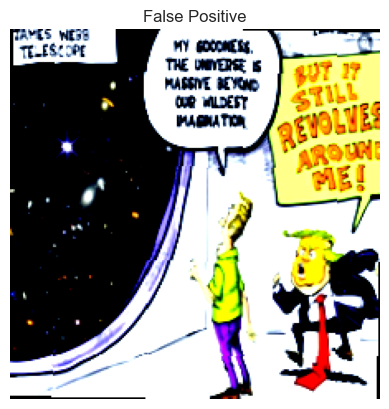

False Positive: Text='name 1 thing you trust more than the joe biden ore...', Label=0.0, Pred=1.0


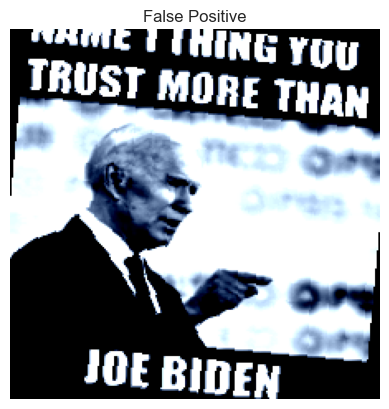

False Negative: Text='everything i don't like, must be banned.  liberal  everythin...', Label=1.0, Pred=0.0


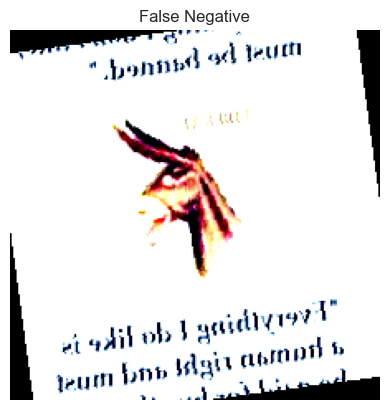

False Negative: Text='use this ov not this 0 soluzame...', Label=1.0, Pred=0.0


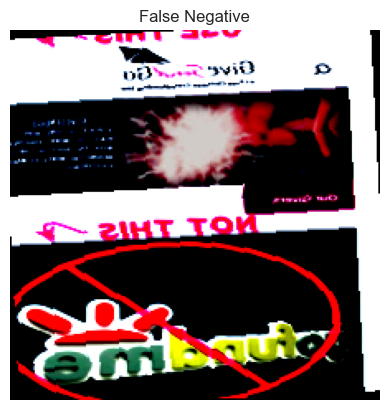

False Negative: Text='so much damage in such a small amount of time...', Label=1.0, Pred=0.0


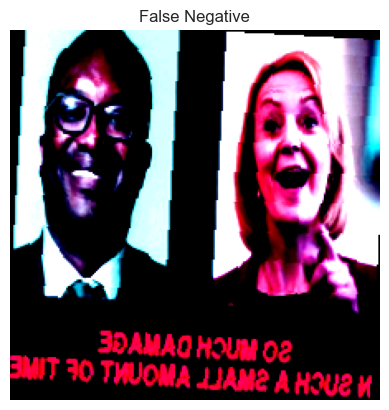


Accuracy: 0.7567, Precision: 0.7353, Recall: 0.6875, F1: 0.6993


In [8]:
import os
import re
import torch
import open_clip
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn
from torchvision.transforms import Compose


DROPOUT = 0.3
LEARNING_RATE = 0.01
WEIGHT_DECAY = 0.0001
SCHEDULER = 'LinearLR'  
UNLOCKED = False       
EPOCHS = 10
BATCH_SIZE = 8


my_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    #transforms.ToTensor(),
])

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="RN50",
    pretrained="openai",
    device=device
)



full_transform = Compose([
    my_transforms,
    preprocess 
])

tokenizer = open_clip.get_tokenizer("RN50")


def load_annotations(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

class RawMultimodalDataset(Dataset):
    def __init__(self, annotations, img_folder, label_encoder, transform=None):
        self.annotations = annotations
        self.img_folder = img_folder
        self.label_encoder = label_encoder
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        item = self.annotations[idx]
        text = re.sub(r"\\n|\n|\\|\s+", " ", item["text"].lower()).strip()
        image_path = os.path.join(self.img_folder, item["label"], item["image"])
        image = Image.open(image_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image) 
    
        label = self.label_encoder.transform([item["label"]])[0]
        return text, image, torch.tensor(label, dtype=torch.float32), item["image"], item["label"]


def compute_embeddings(dataset):
    features, labels, meta = [], [], []
    for text, image, label, img_name, lbl_name in tqdm(dataset, desc="Computing Embeddings"):
        image_tensor = image.unsqueeze(0).to(device)
        text_tokens = tokenizer([text]).to(device)
        with torch.no_grad():
            img_feat = clip_model.encode_image(image_tensor)
            txt_feat = clip_model.encode_text(text_tokens)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
            fused = torch.cat([img_feat, txt_feat], dim=-1)
        features.append(fused.squeeze(0).cpu())
        labels.append(label)
        meta.append((text, image, label, img_name, lbl_name))
    return torch.stack(features), torch.tensor(labels), meta

class PrecomputedDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.classifier(x)


def train_classifier(train_loader, val_loader, input_dim):
    model = MultimodalClassifier(input_dim=input_dim, dropout=DROPOUT).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    scheduler = None
    
    if SCHEDULER == 'StepLR':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif SCHEDULER == 'LinearLR':
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.9, total_iters=EPOCHS)
    elif SCHEDULER == 'ExponentialLR':
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    elif SCHEDULER == 'CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    else:
        scheduler = None
    
  
    criterion = nn.BCELoss()

    for epoch in range(EPOCHS):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}/{EPOCHS} completed")
    return model


def evaluate(model, features, labels, metadata):
    model.eval()
    preds = (model(features.to(device)).squeeze() > 0.5).float().cpu()
    labels = labels.cpu()

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro', zero_division=0)
    rec = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    cm = confusion_matrix(labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    
    print("\nFalse Positives and False Negatives:")
    count_fp, count_fn = 0, 0
    for i, p in enumerate(preds): 
        if p == 1.0 and labels[i] == 0.0 and count_fp < 3:
            print(f"False Positive: Text='{metadata[i][0][:60]}...', Label={labels[i]}, Pred={p}")
            plt.imshow(metadata[i][1].permute(1, 2, 0).cpu().numpy())
            plt.title("False Positive")
            plt.axis('off')
            plt.show()
            count_fp += 1
        elif p == 0.0 and labels[i] == 1.0 and count_fn < 3:
            print(f"False Negative: Text='{metadata[i][0][:60]}...', Label={labels[i]}, Pred={p}")
            plt.imshow(metadata[i][1].permute(1, 2, 0).cpu().numpy())
            plt.title("False Negative")
            plt.axis('off')
            plt.show()
            count_fn += 1

    print(f"\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")


if __name__ == "__main__":
    TRAIN_DATA_DIR = "../pre_processing/dataset/train/"
    VAL_DATA_DIR = "../pre_processing/dataset/val/"
    TEST_DATA_DIR = "../pre_processing/dataset/test/"
    TRAIN_ANNOTATIONS_PATH = '../pre_processing/dataset/train.json'
    VAL_ANNOTATIONS_PATH = '../pre_processing/dataset/val.json'
    TEST_ANNOTATIONS_PATH = '../pre_processing/dataset/test.json'

    train_annotations = load_annotations(TRAIN_ANNOTATIONS_PATH)
    val_annotations = load_annotations(VAL_ANNOTATIONS_PATH)
    test_annotations = load_annotations(TEST_ANNOTATIONS_PATH)

    all_labels = [a["label"] for a in train_annotations + val_annotations + test_annotations]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)

    # Con la transform unificata    
    train_raw = RawMultimodalDataset(train_annotations, TRAIN_DATA_DIR, label_encoder, transform=full_transform)
    val_raw = RawMultimodalDataset(val_annotations, VAL_DATA_DIR, label_encoder, transform=full_transform)
    test_raw = RawMultimodalDataset(test_annotations, TEST_DATA_DIR, label_encoder, transform=full_transform)

    train_features, train_labels, _ = compute_embeddings(train_raw)
    val_features, val_labels, _ = compute_embeddings(val_raw)
    test_features, test_labels, test_meta = compute_embeddings(test_raw)

    train_dataset = PrecomputedDataset(train_features, train_labels)
    val_dataset = PrecomputedDataset(val_features, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    input_dim = train_features.shape[1]
    model = train_classifier(train_loader, val_loader, input_dim)
    evaluate(model, test_features, test_labels, test_meta)

    #torch.save(model.state_dict(), "clip_classifier_final.pt")


C:\Users\conca\Documents\progetti\progettoNLP\venv\lib\site-packages\open_clip\factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(
Computing Embeddings: 100%|██████████| 300/300 [00:13<00:00, 22.90it/s]


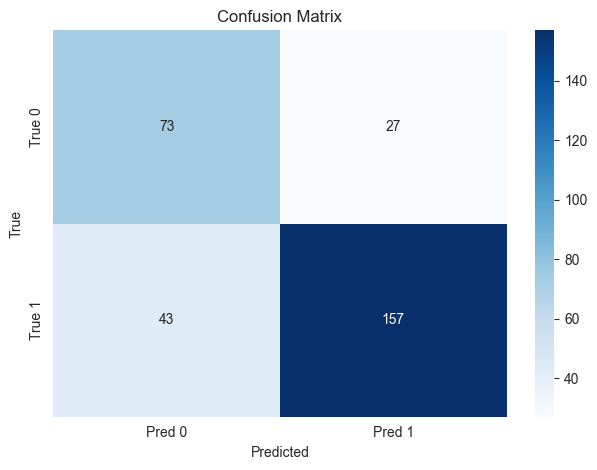


False Positives and False Negatives:
False Negative: Text='what if.. we were honest with our k governments and weathe f...', Label=1.0, Pred=0.0


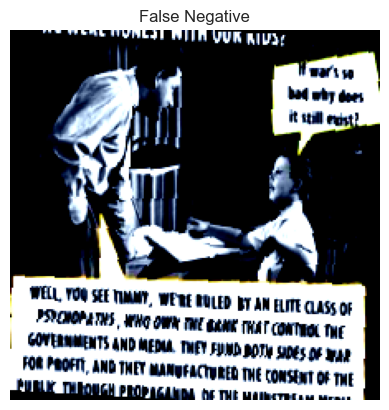

False Positive: Text='*** senate republicans @nrsc .@edmarkey, this you? #weneedni...', Label=0.0, Pred=1.0


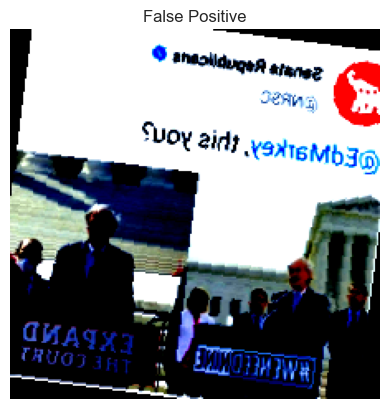

False Negative: Text='just ust doing doing my jub   just doing my job.   just doin...', Label=1.0, Pred=0.0


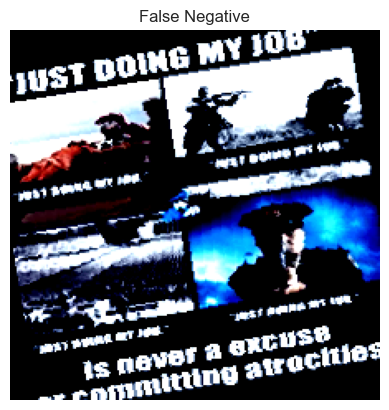

False Positive: Text='my generation grew up looking for pennies, fireflies, ladybu...', Label=0.0, Pred=1.0


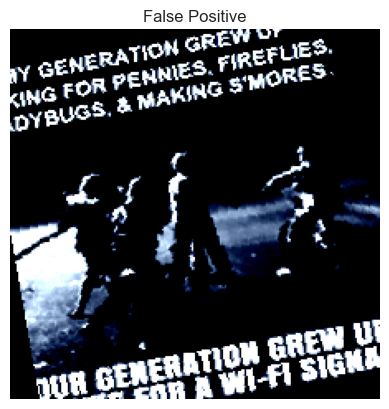

False Negative: Text='everything i don't like, must be banned.  liberal  everythin...', Label=1.0, Pred=0.0


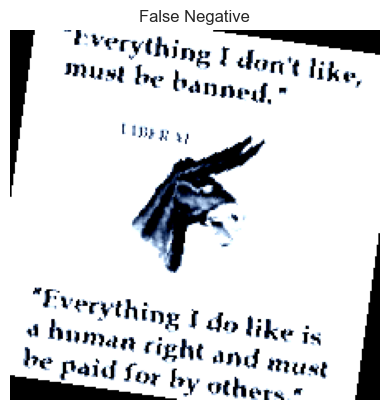

False Positive: Text='sean rayford/getty images nyc mayor bill de blasio drops out...', Label=0.0, Pred=1.0


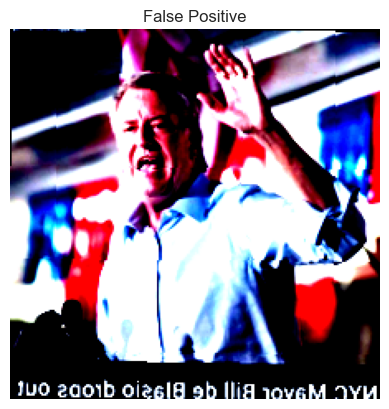


Accuracy: 0.7667, Precision: 0.7413, Recall: 0.7575, F1: 0.7468


In [7]:
# Questo carica il modello salvato

import os
import re
import torch
import open_clip
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn as nn


BATCH_SIZE = 8

dropout = 0.3
lr = 0.01
wd = 0.0001
sched_name = "LinearLR"
unlock = "False"
#MODEL_PATH = f"./saves_models/clip_rn50_d{dropout}_lr{lr}_wd{wd}_sched{sched_name}.pt"
MODEL_PATH = f"./saves_models/openai_rn50_drop{dropout}_lrs{lr}_weights_{wd}_sched_{sched_name}_unlock{unlock}_augmented"


device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    model_name="RN50",
    pretrained="openai",
    device=device
)
tokenizer = open_clip.get_tokenizer("RN50")


def load_annotations(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

class RawMultimodalDataset(Dataset):
    def __init__(self, annotations, img_folder, label_encoder, transform=None):
        self.annotations = annotations
        self.img_folder = img_folder
        self.label_encoder = label_encoder
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        item = self.annotations[idx]
        text = re.sub(r"\\n|\n|\\|\s+", " ", item["text"].lower()).strip()
        image_path = os.path.join(self.img_folder, item["label"], item["image"])
        image = Image.open(image_path).convert("RGB")
    
        if self.transform:
            image = self.transform(image)  # 🔥 Trasforma in tensor qui
    
        label = self.label_encoder.transform([item["label"]])[0]
        return text, image, torch.tensor(label, dtype=torch.float32), item["image"], item["label"]



def compute_embeddings(dataset):
    features, labels, meta = [], [], []
    for text, image, label, img_name, lbl_name in tqdm(dataset, desc="Computing Embeddings"):
        image_tensor = image.unsqueeze(0).to(device)
        text_tokens = tokenizer([text]).to(device)
        with torch.no_grad():
            img_feat = clip_model.encode_image(image_tensor)
            txt_feat = clip_model.encode_text(text_tokens)
            img_feat /= img_feat.norm(dim=-1, keepdim=True)
            txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
            fused = torch.cat([img_feat, txt_feat], dim=-1)
        features.append(fused.squeeze(0).cpu())
        labels.append(label)
        meta.append((text, image, label, img_name, lbl_name))
    return torch.stack(features), torch.tensor(labels), meta

class PrecomputedDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class MultimodalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.classifier(x)


def evaluate(model, features, labels, metadata):
    model.eval()
    preds = (model(features.to(device)).squeeze() > 0.5).float().cpu()
    labels = labels.cpu()

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro', zero_division=0)
    rec = recall_score(labels, preds, average='macro', zero_division=0)
    f1 = f1_score(labels, preds, average='macro', zero_division=0)
    cm = confusion_matrix(labels, preds)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    print("\nFalse Positives and False Negatives:")
    count_fp, count_fn = 0, 0
    for i, p in enumerate(preds):
        if p == 1.0 and labels[i] == 0.0 and count_fp < 3:
            print(f"False Positive: Text='{metadata[i][0][:60]}...', Label={labels[i]}, Pred={p}")
            #plt.imshow(metadata[i][1])
            plt.imshow(metadata[i][1].permute(1, 2, 0).cpu().numpy())
            plt.title("False Positive")
            plt.axis('off')
            plt.show()
            count_fp += 1
        elif p == 0.0 and labels[i] == 1.0 and count_fn < 3:
            print(f"False Negative: Text='{metadata[i][0][:60]}...', Label={labels[i]}, Pred={p}")
            #plt.imshow(metadata[i][1])
            plt.imshow(metadata[i][1].permute(1, 2, 0).cpu().numpy())
            plt.title("False Negative")
            plt.axis('off')
            plt.show()
            count_fn += 1

    print(f"\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")


if __name__ == "__main__":
    TEST_DATA_DIR = "../pre_processing/dataset/test/"
    TEST_ANNOTATIONS_PATH = '../pre_processing/dataset/test.json'
    TRAIN_ANNOTATIONS_PATH = '../pre_processing/dataset/train.json'
    VAL_ANNOTATIONS_PATH = '../pre_processing/dataset/val.json'

    train_annotations = load_annotations(TRAIN_ANNOTATIONS_PATH)
    val_annotations = load_annotations(VAL_ANNOTATIONS_PATH)
    test_annotations = load_annotations(TEST_ANNOTATIONS_PATH)
    
   
    all_labels = [a["label"] for a in train_annotations + val_annotations + test_annotations]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)

     # Con la transform unificata    
    test_raw = RawMultimodalDataset(test_annotations, TEST_DATA_DIR, label_encoder, transform=full_transform)
    test_features, test_labels, test_meta = compute_embeddings(test_raw)

    input_dim = test_features.shape[1]
    model = MultimodalClassifier(input_dim=input_dim).to(device)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

    evaluate(model, test_features, test_labels, test_meta)
